In [76]:
# Written by Margot Yuan (AMSC)
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math

In [77]:
def ExactSolution(x,y):
    return y.pow(2)*torch.sin(math.pi*x)

In [78]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

tensor([[0.1250, 0.1250],
        [0.1250, 0.2500],
        [0.1250, 0.3750],
        [0.1250, 0.5000],
        [0.1250, 0.6250],
        [0.1250, 0.7500],
        [0.1250, 0.8750],
        [0.2500, 0.1250],
        [0.2500, 0.2500],
        [0.2500, 0.3750],
        [0.2500, 0.5000],
        [0.2500, 0.6250],
        [0.2500, 0.7500],
        [0.2500, 0.8750],
        [0.3750, 0.1250],
        [0.3750, 0.2500],
        [0.3750, 0.3750],
        [0.3750, 0.5000],
        [0.3750, 0.6250],
        [0.3750, 0.7500],
        [0.3750, 0.8750],
        [0.5000, 0.1250],
        [0.5000, 0.2500],
        [0.5000, 0.3750],
        [0.5000, 0.5000],
        [0.5000, 0.6250],
        [0.5000, 0.7500],
        [0.5000, 0.8750],
        [0.6250, 0.1250],
        [0.6250, 0.2500],
        [0.6250, 0.3750],
        [0.6250, 0.5000],
        [0.6250, 0.6250],
        [0.6250, 0.7500],
        [0.6250, 0.8750],
        [0.7500, 0.1250],
        [0.7500, 0.2500],
        [0.7500, 0.3750],
        [0.7

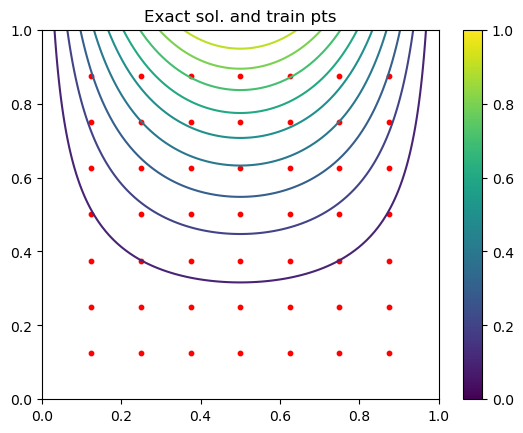

In [79]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
# plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.contour(xtest_grid.numpy(), ytest_grid.numpy(), sol_exact.numpy(), torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [80]:
# x = np.linspace(0,1,100)
# y = np.linspace(0,1,100)
# x_train, y_train = np.meshgrid(x,y)
# train_data = torch.tensor(np.hstack((x_train.ravel()[:,None],y_train.ravel()[:,None])),\
#                          dtype = torch.float32)
# train_data.requires_grad_(True)

In [81]:
# Feedforward neural network with 1 hidden layer
class NN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        out = torch.sigmoid(self.linear1(xb))
        return self.linear2(out)

def SolutionModel(x, y, NN):
    """Solution model u(x, y) = A(x, y) + x(1-x)y(1-y) * NN(x, y; w)"""
    f0 = torch.zeros_like(y)
    f1 = torch.zeros_like(y)
    g0 = torch.zeros_like(x)
    g1 = torch.sin(torch.pi * x)

    A1 = (1 - x) * f0
    A2 = x * f1
    A3 = (1 - y) * (g0 - ((1 - x) * 0 + x * 0))
    A4 = y * (g1 - ((1 - x) * 0 + x * 0))  # f0(0) = f1(1) = 0

    A = A1 + A2 + A3 + A4
    B = x * (1 - x) * y * (1 - y)

    sol = A[..., None] + B[..., None] * NN
    return sol


def Solution(x, y, NN):
    """Analytical-inspired form of u(x, y)"""
    f0 = torch.zeros_like(y)
    f1 = torch.zeros_like(y)
    g0 = torch.zeros_like(x)
    g1 = torch.sin(torch.pi * x)

    A1 = (1 - x) * f0
    A2 = x * f1
    A3 = (1 - y) * (g0 - ((1 - x) * 0 + x * 0))
    A4 = y * (g1 - ((1 - x) * 0 + x * 0))  # f0(0) = f1(1) = 0

    A = A1 + A2 + A3 + A4
    B = x * (1 - x) * y * (1 - y)

    sol = A + B * NN
    return sol


def RHS(x, y):
    """Right-hand side of the Poisson equation"""
    return (2 - (torch.pi ** 2) * y ** 2) * torch.sin(torch.pi * x)

In [82]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [83]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [84]:
loss1 = []
for epoch in range(2000):
    TOL = 1.0e-6
    for X,y in train_dl:
        optimizer.zero_grad()
        nn_approx = model(X)
        Q = SolutionModel(X[:,0],X[:,1],nn_approx)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])

        
        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break
    loss1.append(loss.detach().numpy())

loss at epoch 1 is 6.836564540863037
loss at epoch 101 is 0.29997655749320984
loss at epoch 201 is 0.2781849503517151
loss at epoch 301 is 0.26663491129875183
loss at epoch 401 is 0.2586292028427124
loss at epoch 501 is 0.24755293130874634
loss at epoch 601 is 0.2283599078655243
loss at epoch 701 is 0.19285233318805695
loss at epoch 801 is 0.13770848512649536
loss at epoch 901 is 0.08189859241247177
loss at epoch 1001 is 0.046591468155384064
loss at epoch 1101 is 0.02955014444887638
loss at epoch 1201 is 0.021171968430280685
loss at epoch 1301 is 0.016412632539868355
loss at epoch 1401 is 0.013197747990489006
loss at epoch 1501 is 0.010684750974178314
loss at epoch 1601 is 0.008562409318983555
loss at epoch 1701 is 0.0067353034391999245
loss at epoch 1801 is 0.005187008995562792
loss at epoch 1901 is 0.003925842698663473


Max error =  0.0012982152
Mean error =  0.0003935934
RMS error =  0.0005030103


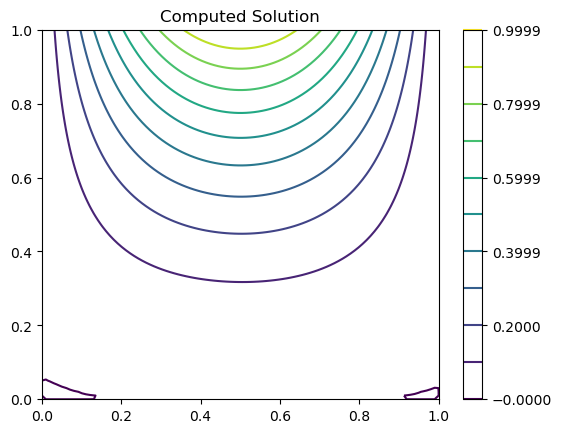

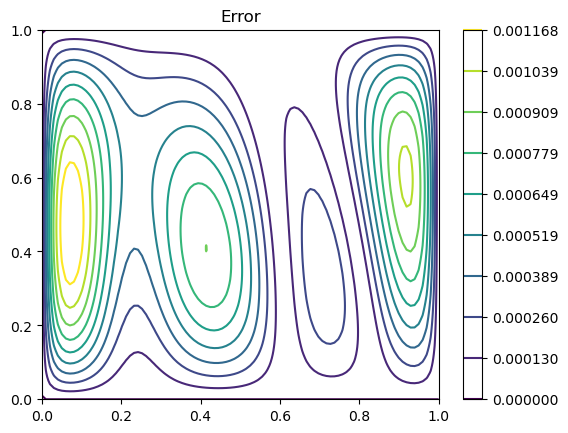

In [85]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        pt = torch.tensor([[xtest_grid[i,j],ytest_grid[i,j]]])
        sol_test[i,j] = Solution(xtest_grid[i,j],ytest_grid[i,j],model(pt))
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))

Text(0, 0.5, 'Loss')

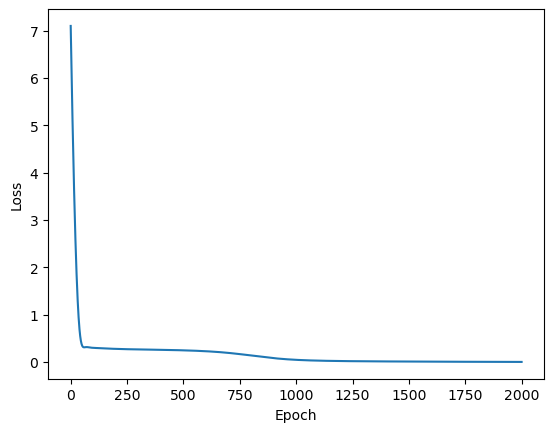

In [86]:
plt.figure()
plt.plot(loss1)
plt.xlabel("Epoch")
plt.ylabel("Loss")